# Plant Pathology
---
Model trained with KFold cross validation

In [1]:
from fastai2.vision.all import *
from fastai2.callback.all import *

In [2]:
from efficientnet_pytorch import EfficientNet

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from collections import Counter
import gc

## Load and prepare the data

In [4]:
path = Path('../../storage/plant-pathology')
Path.BASE_PATH = path
path.ls()

(#5) [Path('images'),Path('sample_submission.csv'),Path('test.csv'),Path('train.csv'),Path('.ipynb_checkpoints')]

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [6]:
test_df = pd.read_csv(path/'test.csv')

### Class Distribution

In [7]:
idx_labels = {}

In [8]:
counter = Counter()
for idx, row in df.iterrows():
    label = row.loc[row == 1].index[0]
    counter[label] += 1
    idx_labels[idx] = label

In [9]:
counter

Counter({'scab': 592, 'multiple_diseases': 91, 'healthy': 516, 'rust': 622})

*Plot bar chart for distribution of images in the dataset*

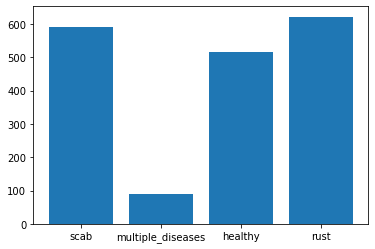

In [10]:
plt.bar([0, 1, 2, 3], counter.values())
plt.xticks([0, 1, 2, 3], counter.keys());

*Class Distribution is imbalanced, let's oversample the minority classes*

In [11]:
def oversample(df: pd.DataFrame, cond, limit: int):
    grouped = df.groupby(cond)
    new_samples = []
    
    for name, group in grouped:
        if len(group) < limit:
            new_samples.append(group.sample(limit, replace=True))
        else:
            new_samples.append(group)
    return pd.concat(new_samples)

In [12]:
max(counter.values())

622

In [13]:
df_oversampled = oversample(df, idx_labels, max(counter.values()))

*Sanity check*

In [14]:
idx_labels = []
counter = Counter()
for idx, row in df_oversampled.iterrows():
    label = row.loc[row == 1].index[0]
    counter[label] += 1
    idx_labels.append(label)

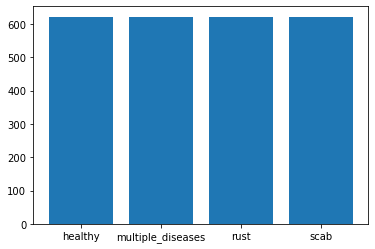

In [15]:
plt.bar([0, 1, 2, 3], counter.values())
plt.xticks([0, 1, 2, 3], counter.keys());

In [16]:
df_oversampled.head()

,image_id,healthy,multiple_diseases,rust,scab
532,Train_532,1,0,0,0
295,Train_295,1,0,0,0
1611,Train_1611,1,0,0,0
219,Train_219,1,0,0,0
2,Train_2,1,0,0,0


In [17]:
len(idx_labels), len(df_oversampled)

(2488, 2488)

In [18]:
idx_labels[:5]

['healthy', 'healthy', 'healthy', 'healthy', 'healthy']

In [19]:
idx_labels = np.array(idx_labels)
idx_labels[:5]

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy'],
      dtype='<U17')

In [20]:
imgs = df_oversampled['image_id'].to_numpy()
imgs[:5]

array(['Train_532', 'Train_295', 'Train_1611', 'Train_219', 'Train_2'],
      dtype=object)

### Define Dataloaders

In [21]:
def get_dls(size, bs, valid_idx):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_x=ColReader('image_id', pref=path/'images', suff='.jpg'),
                       get_y=Pipeline([lambda r: r.loc[r==1].index[0]]),
                       splitter=IndexSplitter(valid_idx),
                       item_tfms=Resize(size*2),
                       batch_tfms=[*aug_transforms(size=size, min_scale=0.75, flip_vert=True),
                                   Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(df_oversampled, bs=bs)

**Define roc metric**

In [22]:
def roc(preds, targs):
    preds, targs = preds.cpu(), targs.cpu()
    labels = range(dls.c)
    targs = np.eye(dls.c)[targs]
    return np.mean([roc_auc_score(targs[:, i], preds[:, i]) for i in labels])

## Trainig loop for KFold cross validation

In [25]:
test_preds = []
test_preds_tta = []

In [26]:
skf = StratifiedKFold(n_splits=10, shuffle=True)

for _, valid_idx in skf.split(imgs, idx_labels):
    dls = get_dls(512, 32, valid_idx)
    opt_func = partial(Adam, wd=0.01, eps=1e-8)
    model = EfficientNet.from_pretrained("efficientnet-b3", advprop=True, num_classes=dls.c)
    learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy, AccumMetric(roc, flatten=False)]).to_fp16()
    
    learn.fit_one_cycle(10, 1e-3)
    
    # evaluate on test set
    test_dl = learn.dls.test_dl(test_df, with_labels=False)
    probs, _ = learn.get_preds(dl=test_dl)
    probs_tta = learn.tta(dl=test_dl)
    
    test_preds.append(probs)
    test_preds_tta.append(probs_tta)
    
    del learn
    torch.cuda.empty_cache()
    gc.collect()

Loaded pretrained weights for efficientnet-b3


epoch,train_loss,valid_loss,accuracy,roc,time
0,0.930119,0.861113,0.742972,0.964236,02:34
1,0.661571,1.756882,0.610442,0.891736,02:24
2,0.555803,0.600984,0.919679,0.995257,02:26
3,0.508532,0.501538,0.927711,0.994999,02:24
4,0.492689,0.456281,0.975904,0.998125,02:28
5,0.444435,0.454690,0.955823,0.993963,02:24
6,0.415401,0.366003,0.995984,0.999978,02:30
7,0.401371,0.373515,0.987952,0.999741,02:33
8,0.389090,0.369607,0.991968,0.999612,02:32
9,0.380930,0.364382,0.991968,0.999914,02:29


Loaded pretrained weights for efficientnet-b3


epoch,train_loss,valid_loss,accuracy,roc,time
0,0.931053,0.873514,0.702811,0.956116,02:33
1,0.633275,0.700934,0.827309,0.975364,02:31
2,0.547824,1.009194,0.803213,0.979286,02:27
3,0.516300,0.554647,0.923695,0.988192,02:28
4,0.492592,0.448629,0.967871,0.996055,02:30
5,0.439170,0.433927,0.963855,0.993488,02:26
6,0.416240,0.403930,0.975904,0.998109,02:25
7,0.397170,0.397857,0.975904,0.997928,02:27
8,0.382757,0.394232,0.983936,0.998929,02:31
9,0.378430,0.393489,0.983936,0.998608,02:24


Loaded pretrained weights for efficientnet-b3


epoch,train_loss,valid_loss,accuracy,roc,time
0,0.938520,0.861308,0.690763,0.957183,02:28
1,0.643730,0.569406,0.887550,0.987032,02:25
2,0.586576,0.757881,0.843373,0.962161,02:27
3,0.525547,0.474193,0.951807,0.993289,02:23
4,0.482906,0.457897,0.943775,0.997307,02:27
5,0.452931,0.401616,0.971888,0.999678,02:23
6,0.432550,0.380700,0.987952,0.999935,02:27
7,0.404019,0.386110,0.983936,0.999278,02:23
8,0.385933,0.367036,0.987952,0.999957,02:26
9,0.379661,0.362350,0.991968,1.000000,02:23


Loaded pretrained weights for efficientnet-b3


epoch,train_loss,valid_loss,accuracy,roc,time
0,0.941355,0.990236,0.710843,0.972522,02:25
1,0.647278,0.518129,0.935743,0.993548,02:19
2,0.553538,0.715548,0.891566,0.981332,02:19
3,0.517610,0.496131,0.959839,0.993524,02:18
4,0.464426,0.440647,0.963855,0.998925,02:19
5,0.436078,0.455196,0.939759,0.998007,02:18
6,0.421667,0.365101,0.995984,0.999935,02:19
7,0.397681,0.367475,0.995984,1.000000,02:20
8,0.382907,0.362081,0.995984,1.000000,02:19
9,0.375599,0.361251,0.995984,1.000000,02:20


Loaded pretrained weights for efficientnet-b3


epoch,train_loss,valid_loss,accuracy,roc,time
0,0.945438,0.961760,0.690763,0.952563,02:19
1,0.634950,0.809167,0.722892,0.959802,02:19
2,0.572729,0.729531,0.859438,0.984944,02:20
3,0.506786,0.533489,0.951807,0.989643,02:20
4,0.477224,0.443618,0.959839,0.991757,02:20
5,0.434926,0.388332,0.991968,0.997865,02:20
6,0.421211,0.375041,0.995984,0.997226,02:19
7,0.401148,0.372151,0.995984,0.999015,02:21
8,0.383901,0.367529,0.995984,0.998740,02:22
9,0.377777,0.367522,0.995984,0.998847,02:20


Loaded pretrained weights for efficientnet-b3


epoch,train_loss,valid_loss,accuracy,roc,time
0,0.963349,0.952935,0.738956,0.957605,02:20
1,0.645056,0.825554,0.819277,0.972942,02:19
2,0.584569,0.773333,0.831325,0.961757,02:20
3,0.526300,0.997231,0.879518,0.943329,02:19
4,0.475788,0.415410,0.979920,0.995045,02:20
5,0.438898,0.417952,0.975904,0.996098,02:20
6,0.410619,0.396779,0.983936,0.996389,02:20
7,0.396680,0.395042,0.983936,0.998212,02:20
8,0.390387,0.390660,0.983936,0.997835,02:20
9,0.380434,0.391266,0.983936,0.998234,02:20


Loaded pretrained weights for efficientnet-b3


epoch,train_loss,valid_loss,accuracy,roc,time
0,0.921683,1.163323,0.574297,0.932049,02:20
1,0.643450,0.714456,0.879518,0.967134,02:20
2,0.580486,0.651074,0.895582,0.976133,02:21
3,0.520565,0.433934,0.971888,0.997719,02:21
4,0.487811,0.772920,0.803213,0.982014,02:21
5,0.439900,0.412063,0.975904,0.994380,02:21
6,0.419886,0.389420,0.987952,0.999936,02:21
7,0.404044,0.375689,0.983936,0.999850,02:21
8,0.396676,0.381914,0.983936,0.998469,02:23
9,0.386191,0.379285,0.983936,0.999591,02:21


Loaded pretrained weights for efficientnet-b3


epoch,train_loss,valid_loss,accuracy,roc,time
0,0.952274,1.409001,0.582329,0.916448,02:20
1,0.638157,0.638390,0.855422,0.988409,02:21
2,0.593168,0.541404,0.923695,0.978205,02:21
3,0.518361,0.589619,0.923695,0.986142,02:21
4,0.468258,0.485869,0.955823,0.991302,02:21
5,0.438919,0.416199,0.979920,0.996056,02:21
6,0.420541,0.392835,0.979920,0.997671,02:23
7,0.400654,0.377499,0.983936,0.999763,02:21
8,0.386330,0.372586,0.983936,0.999785,02:21
9,0.382716,0.370776,0.983936,0.999828,02:21


Loaded pretrained weights for efficientnet-b3


epoch,train_loss,valid_loss,accuracy,roc,time
0,0.911400,1.276870,0.548387,0.936698,02:21
1,0.651743,0.567781,0.899194,0.981530,02:22
2,0.581940,1.448079,0.665323,0.923669,02:21
3,0.521315,0.459153,0.967742,0.991296,02:22
4,0.478480,0.662067,0.883065,0.991242,02:21
5,0.447119,0.460799,0.959677,0.994103,02:22
6,0.414761,0.369709,0.991935,0.999957,02:21
7,0.397297,0.360201,0.995968,1.000000,02:21
8,0.388695,0.359936,0.991935,1.000000,02:22
9,0.380567,0.357810,0.995968,1.000000,02:21


In [75]:
len(test_preds)

10

In [38]:
len(test_preds_tta)

10

In [84]:
test_preds[2]

tensor([[0.0376, 0.0308, 0.9032, 0.0284],
        [0.0236, 0.0126, 0.9360, 0.0278],
        [0.0261, 0.0195, 0.0225, 0.9319],
        ...,
        [0.0235, 0.0167, 0.9353, 0.0246],
        [0.9411, 0.0188, 0.0164, 0.0237],
        [0.0250, 0.0308, 0.0225, 0.9217]])

In [77]:
tot

tensor([[0.2875, 0.2842, 9.2055, 0.2228],
        [0.2370, 0.2324, 9.2530, 0.2776],
        [0.2482, 0.2262, 0.2395, 9.2861],
        ...,
        [0.2570, 0.2220, 9.2871, 0.2339],
        [9.2439, 0.2199, 0.2810, 0.2552],
        [0.2087, 0.6703, 0.2369, 8.8841]])

In [70]:
for i in test_preds_tta[1:]:
    tot += i[0]

In [71]:
tot = tot / 10

In [72]:
tot

tensor([[0.0288, 0.0284, 0.9205, 0.0223],
        [0.0237, 0.0232, 0.9253, 0.0278],
        [0.0248, 0.0226, 0.0240, 0.9286],
        ...,
        [0.0257, 0.0222, 0.9287, 0.0234],
        [0.9244, 0.0220, 0.0281, 0.0255],
        [0.0209, 0.0670, 0.0237, 0.8884]])

In [63]:
subm = pd.read_csv(path/'sample_submission.csv')

In [64]:
subm.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


In [65]:
subm.iloc[:, 1:] = tot

In [66]:
subm.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.031902,0.020387,0.930033,0.017678
1,Test_1,0.025699,0.021939,0.927864,0.024498
2,Test_2,0.027060,0.023846,0.030829,0.918265
3,Test_3,0.922587,0.025096,0.024526,0.027792
4,Test_4,0.026347,0.032630,0.918857,0.022165


In [67]:
subm.to_csv("k2_norm.csv", index=False)